# Name data: `common_Dstto3piHEP`

# Compute the sWeights 
1. Fit on $m(3\pi)$ for $|m(3\pi) - 1968|<50$
    - Signal shape: Gaussian
    - Background shape: Exponential
2. Compute the associated probability and sWeights
3. Plot the sWeight (as a check)
4. Save the sWeight in a root file

The sWeights are computed with `hepstats` (and not `hep_ml`). This is why I added `HEP` to the name of the data.

The root files is saved in `output/root/common/`

In [1]:
name_data = 'common_DstTO3pi'

In [15]:
import zfit
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from hepstats.splot import compute_sweights

from bd2dst3pi.locations import loc
from bd2dst3pi.definitions import years, magnets

import sys
sys.path.append(loc.SCRIPTS)
from load_save_data import load_data, save_dataframe, dump_pickle, json_to_latex_table, add_constr_Dst
from plot.tool import fix_plot, save_file, show_grid
import plot.histogram as h
from plot.fit import plot_hist_fit_particle
from fit import launch_fit, define_zparams, save_params
from variables import name_params_tau

## Retrieve data

In [3]:
df = load_data(years, magnets, type_data='common', vars=['B0_M','tau_M', 'Dst_M'],
                            cut_DeltaM=True)
df = add_constr_Dst(df)

/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//common/data/data_90000000_2015_up.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//common/data/data_90000000_2015_down.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//common/data/data_90000000_2016_up.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//common/data/data_90000000_2016_down.root
cut on DeltaM has removed 425088 over 935261 events


In [4]:
size_tau_M = 50.
mean_tau_M = 1969.
low_tau_M = mean_tau_M - size_tau_M
high_tau_M = mean_tau_M + size_tau_M
df_Ds = df.query(f"abs(tau_M-{mean_tau_M})<={size_tau_M}")

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


## Histogram

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/tau_M_common_DstTO3pi


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='$m$($3\\pi$) [MeV/$c^2$]', ylabel='Candidates / (1 MeV/$c^2$)'>)

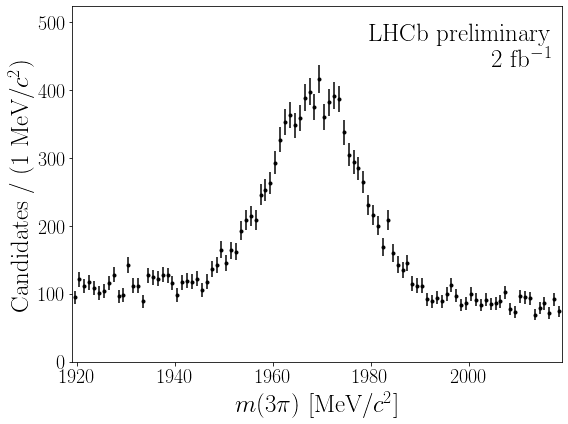

In [5]:
h.plot_hist_particle({name_data:df_Ds},'tau_M',
              n_bins = 100, mode_hist = False, colors='black', pos_text_LHC='right')

## Fit to $m(3\pi)$ = gaussian (signal) + exponential (background)

### Initial conditions

In [5]:
n_events_tau_M = len(df_Ds)
initial_values_tau = {
    'mu_tau': {
        'value' : 1969.,
        'low': 1965.,
        'high': 1975.,     
    },
    'sigma_tau': {
        'value' : 9.4,
        'low': 5.,
        'high': 15.,
    },
    'n_bkg_tau': {
        'value' : n_events_tau_M*2/3,
        'low': 0,
        'high': n_events_tau_M,  
    },
    'n_sig_tau': {
        'value' : n_events_tau_M/3,
        'low': 0,
        'high': n_events_tau_M,  
    },
    'lambda_tau': {
        'value' : -0.003,
        'low': -0.01,
        'high': -0.0001  
    }
}

### Parameters and pdf

In [6]:
obs_tau = zfit.Space("x", limits=(low_tau_M, high_tau_M))

zparams_tau = define_zparams(initial_values_tau)

In [7]:
name_params_tau = {
    # Signal
    f'mu_tau':'$\mu_{S}$',
    f'sigma_tau':'$\sigma_{S}$',
    f'n_sig_tau':'$n_{S}$',
    # Combinatorial background
    f'n_bkg_tau':'$n_{bkg,c}$',
    f'lambda_tau':'$\\lambda_{bkg,c}$',
}

In [8]:
gaussian_tau = zfit.pdf.Gauss(zparams_tau["mu_tau"],zparams_tau["sigma_tau"],obs=obs_tau)
exponential_tau = zfit.pdf.Exponential(zparams_tau["lambda_tau"], obs=obs_tau)

gaussian_ext_tau = gaussian_tau.create_extended(zparams_tau["n_sig_tau"])
exp_ext_tau = exponential_tau.create_extended(zparams_tau["n_bkg_tau"])
model_tau = zfit.pdf.SumPDF([gaussian_ext_tau, exp_ext_tau]) # gauss is folded by frac

data_tau = zfit.Data.from_pandas(df_Ds['tau_M'],obs=obs_tau)

### Launch fit

In [9]:
import timeit
start = timeit.default_timer()
result_tau, params_tau = launch_fit(model_tau, data_tau, extended=True)
stop = timeit.default_timer()
print('Time to do the fit: ', stop - start) 


------------------------------------------------------------------
| FCN = -7.151e+04              |     Ncalls=126 (126 total)     |
| EDM = 4.61e-05 (Goal: 0.001)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
name            value    minuit_hesse    at limit
----------  ---------  --------------  ----------
n_sig_tau        6816     +/- 1.3e+02       False
n_bkg_tau        9932     +/- 1.4e+02       Fa

Result of the fit:

    ------------------------------------------------------------------
    | FCN = -7.151e+04              |     Ncalls=126 (126 total)     |
    | EDM = 4.61e-05 (Goal: 0.001)  |            up = 0.5            |
    ------------------------------------------------------------------
    |  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
    ------------------------------------------------------------------
    |     True      |     True      |   False   |       False        |
    ------------------------------------------------------------------
    | Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
    ------------------------------------------------------------------
    |     False     |     True      |   True    |   True    | False  |
    ------------------------------------------------------------------
    name            value    minuit_hesse         minuit_minos    at limit
    ----------  ---------  --------------  -------------------  ----------
    n_sig_tau        6816     +/- 1.3e+02  -1.3e+02   +1.3e+02       False
    n_bkg_tau        9932     +/- 1.4e+02  -1.4e+02   +1.4e+02       False
    mu_tau           1969     +/-    0.17  -   0.17   +   0.18       False
    sigma_tau       9.267     +/-    0.18  -   0.17   +   0.18       False
    lambda_tau  -0.003488     +/- 0.00037  -0.00037   +0.00037       False
    Time to do the fit:  2.776348260231316



/afs/cern.ch/user/c/correian/bd2dst3pi/scripts/plot/fit.py:539: UserWarning: The function <function Space.limits at 0x7f08b3a267a0> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('x',), axes=None, limits=(array([[1919.]]), array([[2019.]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.
  low = float(obs.limits[0])
/afs/cern.ch/user/c/correian/bd2dst3pi/scripts/plot/fit.py:45: UserWarning: The function <function Space.area at 0x7f08b3a2ab90> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('x',), axes=None, limits=(array([[1919.]]), array([[2019.]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.
  return counts.sum() * obs.area() / n_bins


Number of d.o.f. in the model:  5
Reduced chi2:  1.1189082909460164


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/common_DstTO3pi_detail/tau_M_common_DstTO3pi_detail_fit
Number of d.o.f. in the model:  5
Reduced chi2:  1.1189082909460164


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/common_DstTO3pi/tau_M_common_DstTO3pi_fit


(<Figure size 864x720 with 2 Axes>,
 <AxesSubplot:xlabel='$m$($3\\pi$) [MeV/$c^2$]', ylabel='Candidates / (1 MeV/$c^2$)'>,
 <AxesSubplot:ylabel='residuals / $\\sigma$'>)

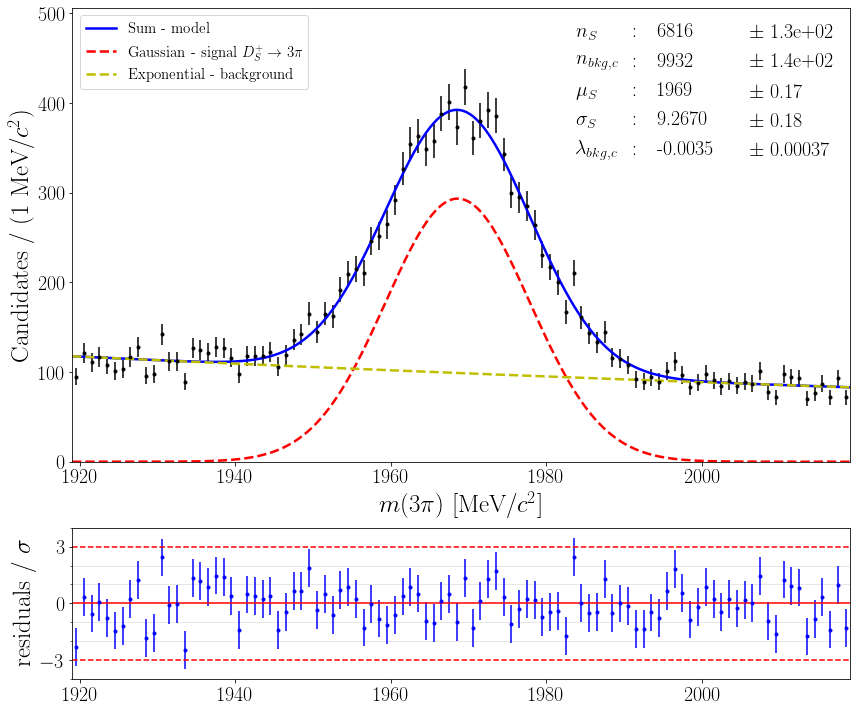

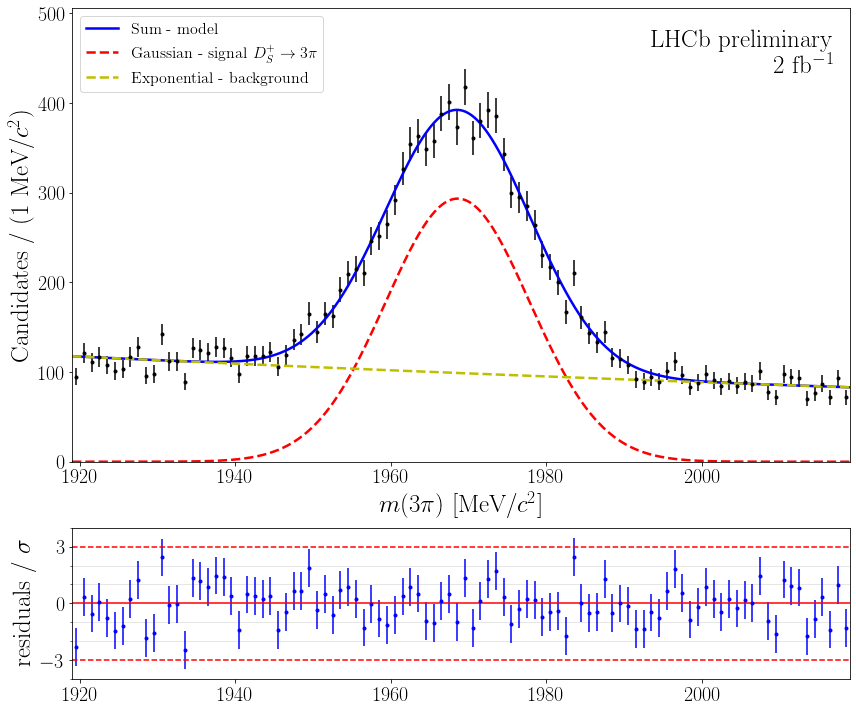

In [10]:
plot_hist_fit_particle(df,'tau_M',models = [model_tau,gaussian_ext_tau,exp_ext_tau], 
                       name_models = ["", '$D_S^+ \\to 3\pi$',''], colors = ['b','r','y'],
                       obs=obs_tau, n_bins = 100,mode_hist = False, name_data=name_data+'_detail', 
                      params=params_tau,name_params=name_params_tau, fontsize_leg=15.)
plot_hist_fit_particle(df,'tau_M',models = [model_tau,gaussian_ext_tau,exp_ext_tau], 
                       name_models = ["", '$D_S^+ \\to 3\pi$',''], colors = ['b','r','y'],
                       obs=obs_tau, n_bins = 100,mode_hist = False, name_data=name_data, 
                       fontsize_leg=16., pos_text_LHC='right')

In [12]:
save_params(params_tau, name_data, True, name_folder=name_data)

parameters saved in /afs/cern.ch/user/c/correian/bd2dst3pi/output/json/common_DstTO3pi/common_DstTO3pi_params.json


In [13]:
json_to_latex_table(name_data, name_data, name_params_tau)

/afs/cern.ch/user/c/correian/bd2dst3pi/output/tables/common_DstTO3pi/common_DstTO3pi_params.tex
\begin{tabular}[t]{lc}
\hline
Variable &Fitted Value\\
\hline\hline
$\lambda_{bkg,c}$&$-0.00349\pm0.00037$\\
\hline
$\mu_{S}$&$1968.59\pm0.17$\\
\hline
$n_{bkg,c}$&$(9.93\pm0.14)\times 10^3$\\
\hline
$n_{S}$&$(6.82\pm0.13)\times 10^3$\\
\hline
$\sigma_{S}$&$9.27\pm0.18$\\
\hline
\end{tabular}


### Correlation between `B0_M`and `tau_M`.
Theoretically speaking, in order to apply the sWeights to 'B0_M', those two variables must not be correlated.

In [11]:
from scipy.stats import pearsonr

In [12]:
low_B0Ds = 5150.
high_B0Ds = 5360.

In [13]:
var = 'Dst_constr_B0_M'
df_Ds = add_constr_Dst(df_Ds)

/afs/cern.ch/user/c/correian/bd2dst3pi/scripts/load_save_data.py:356: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"Dst_constr_{col}"] = df[col] - df['Dst_M'] + Dst_M_PDG


In [14]:
print(np.corrcoef(df_Ds['tau_M'], df_Ds[var]) [0, 1])
print(pearsonr(df_Ds['tau_M'], df_Ds[var])[0])

0.047662460225687375
0.04766246022568738


In [15]:
np.corrcoef(df_Ds['tau_M'], df_Ds['B0_M']) [0, 1]

0.04762547106585079

In [16]:
pearsonr(df_Ds['tau_M'], df_Ds['B0_M'])[0]

0.04762547106585078

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/common_DstTO3pi/tau_M_vs_B0_M


(<Figure size 576x432 with 2 Axes>,
 <AxesSubplot:xlabel='$m$($3\\pi$) [MeV/$c^2$]', ylabel='$m$($D^{*}3\\pi$) [MeV/$c^2$]'>)

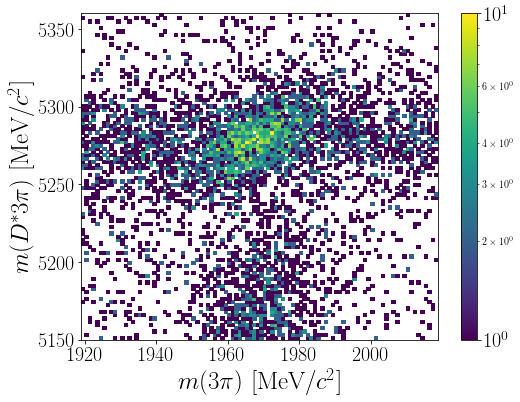

In [20]:
h.plot_hist2d_particle(df_Ds,['tau_M','B0_M'],
            low=[low_tau_M, low_B0Ds],high=[high_tau_M, high_B0Ds], log_scale = True,
            name_folder=name_data)

## Compute sWeights via hepstats

### Computation

In [11]:
weights_hep = compute_sweights(model_tau, df_Ds['tau_M'])

In [12]:
weights_sig = weights_hep[zparams_tau['n_sig_tau']]
weights_bkg = weights_hep[zparams_tau['n_bkg_tau']]

mass = df_Ds['tau_M']

### Plotting

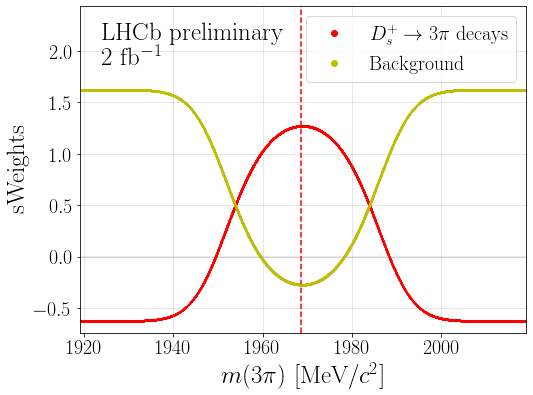

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/common_DstTO3pi/sWeights


In [30]:
fig, ax = plt.subplots(figsize=(8,6))

ax.axhline(0, c='black', ls='-', alpha=0.1)
ax.axvline(float(zparams_tau['mu_tau']), c='red', ls='--')
ax.plot(mass, weights_sig,'.', label='$D_s^+ \\to 3\pi$ decays', markersize=1., color='r')
ax.plot(mass, weights_bkg,'.', label='Background', markersize=1., color='y')
ax.set_xlim(low_tau_M, high_tau_M)



plt.xlabel('$m(3\pi)$ [MeV/$c^2$]',fontsize=25)
plt.ylabel('sWeights',fontsize=25)

ymin, ymax = ax.get_ylim()
#ax.set_ylim(ymin, ymax*1.1)
fix_plot(ax, ymax=1.4, pos_text_LHC=[0.05, 0.95, 'left'], ymin_to0=False)
ax.legend(markerscale=12, fontsize=20)
show_grid(ax)
plt.show()
plt.close()

save_file(fig, 'sWeights', name_folder=name_data)

### Save the dataframe

In [24]:
sWeights_df = pd.DataFrame()
sWeights_df['sWeight'] = weights_sig

In [25]:
save_dataframe(sWeights_df, name_data+'_sWeights', 'sWeights', name_folder='common')

/afs/cern.ch/user/c/correian/bd2dst3pi/output/root/common/common_DstTO3pi_sWeights.root


In [26]:
df_Ds['sWeight'] = weights_sig

/afs/cern.ch/work/c/correian/miniconda/envs/bd2dst3pi_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [28]:
save_dataframe(df_Ds, name_data, 'DecayTree', name_folder='common')

/afs/cern.ch/user/c/correian/bd2dst3pi/output/root/common/common_DstTO3pi.root
